In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import fitz  # PyMuPDF
import re
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


Importing the dataset and making a copy to work on to keep the original dataset untouched

In [3]:
main = pd.read_csv("Crime_Data_from_2020_to_Present.csv")
df = main.copy()

#### Basic Descriptive Statistics

In [5]:
# DR_NO             Division of Records Number: Official file number made up of a 2 digit year, area ID, and 5 digits
# Date Rptd         MM/DD/YYYY
# DATE OCC          MM/DD/YYYY Date Occured
# TIME OCC          In 24 hour military time. Time Occured
# AREA              The LAPD has 21 Community Police Stations referred to as Geographic Areas within the department. These Geographic Areas are sequentially numbered from 1-21.
# AREA NAME         The 21 Geographic Areas or Patrol Divisions are also given a name designation referring a landmark or the surrounding community that it is responsible for.
# Rpt Dist No       A four-digit code that represents a sub-area within a Geographic Area. All crime records reference the "RD" that it occurred in for statistical comparisons. 
# Part 1-2          part_1_2
# Crm Cd            Indicates the crime committed. (Same as Crime Code 1)
# Crm Cd Desc       Defines the Crime Code provided.
# Mocodes           Modus Operandi: Activities associated with the suspect in commission of the crime
# Vict Age          Two character numeric
# Vict Sex          F - Female M - Male X - Unknown
# Vict Descent      A - Other Asian B - Black C - Chinese D - Cambodian F - Filipino G - Guamanian H - Hispanic/Latin/Mexican I - American Indian/Alaskan Native J - Japanese 
#                   K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan U - Hawaiian V - Vietnamese W - White X - Unknown Z - Asian Indian
# Premis Cd         The type of structure, vehicle, or location where the crime took place.
# Premis Desc       Defines the Premise Code provided.
# Weapon Used Cd    The type of weapon used in the crime.
# Weapon Desc       Defines the Weapon Used Code provided.
# Status            Status of the case. (IC is the default)
# Status Desc       Defines the Status Code provided.
# Crm Cd 1          Indicates the crime committed. Crime Code 1 is the primary and most serious one. Crime Code 2, 3, and 4 are respectively less serious offenses. 
# Crm Cd 2          May contain a code for an additional crime, less serious than Crime Code 1.
# Crm Cd 3          May contain a code for an additional crime, less serious than Crime Code 1.
# Crm Cd 4          May contain a code for an additional crime, less serious than Crime Code 1.
# LOCATION          Street address of crime incident rounded to the nearest hundred block to maintain anonymity.
# Cross Street      Cross Street of rounded Address
# LAT               Latitude
# LON               Longtitude


In [6]:
df

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005193,250304214,02/23/2025 12:00:00 AM,02/21/2025 12:00:00 AM,1530,3,Southwest,358,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,3600 MCCLINTOCK AV,NaN,34.0212,-118.2895
1005194,250304203,02/20/2025 12:00:00 AM,02/13/2025 12:00:00 AM,2100,3,Southwest,325,1,522,"VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, B...",...,IC,Invest Cont,522.0,NaN,NaN,NaN,2600 ELLENDALE PL,NaN,34.0307,-118.2923
1005195,250504051,01/14/2025 12:00:00 AM,01/14/2025 12:00:00 AM,1250,5,Harbor,509,1,210,ROBBERY,...,IC,Invest Cont,210.0,NaN,NaN,NaN,24300 WESTERN AV,NaN,33.8046,-118.3074
1005196,251604136,02/27/2025 12:00:00 AM,02/27/2025 12:00:00 AM,1550,16,Foothill,1664,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,NaN,NaN,NaN,11900 SHELDON ST,NaN,34.2404,-118.3922


In [7]:
df.describe()

,DR_NO,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,Weapon Used Cd,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON
count,1.005198e+06,1.005198e+06,1.005198e+06,1.005198e+06,1.005198e+06,1.005198e+06,1.005198e+06,1.005182e+06,327280.000000,1.005187e+06,69159.000000,2314.000000,64.00000,1.005198e+06,1.005198e+06
mean,2.202277e+08,1.339911e+03,1.069098e+01,1.115556e+03,1.400283e+00,5.001458e+02,2.891253e+01,3.056189e+02,363.953651,4.999063e+02,958.105221,984.015990,991.21875,3.399820e+01,-1.180909e+02
std,1.320282e+07,6.510531e+02,6.110385e+00,6.111733e+02,4.899559e-01,2.052635e+02,2.199382e+01,2.193160e+02,123.736081,2.050640e+02,110.354136,52.350982,27.06985,1.610549e+00,5.581812e+00
min,8.170000e+02,1.000000e+00,1.000000e+00,1.010000e+02,1.000000e+00,1.100000e+02,-4.000000e+00,1.010000e+02,101.000000,1.100000e+02,210.000000,310.000000,821.00000,0.000000e+00,-1.186676e+02
25%,2.106169e+08,9.000000e+02,5.000000e+00,5.870000e+02,1.000000e+00,3.310000e+02,0.000000e+00,1.010000e+02,311.000000,3.310000e+02,998.000000,998.000000,998.00000,3.401470e+01,-1.184305e+02
50%,2.209160e+08,1.420000e+03,1.100000e+01,1.139000e+03,1.000000e+00,4.420000e+02,3.000000e+01,2.030000e+02,400.000000,4.420000e+02,998.000000,998.000000,998.00000,3.405890e+01,-1.183225e+02
75%,2.311105e+08,1.900000e+03,1.600000e+01,1.613000e+03,2.000000e+00,6.260000e+02,4.400000e+01,5.010000e+02,400.000000,6.260000e+02,998.000000,998.000000,998.00000,3.416490e+01,-1.182739e+02
max,2.521041e+08,2.359000e+03,2.100000e+01,2.199000e+03,2.000000e+00,9.560000e+02,1.200000e+02,9.760000e+02,516.000000,9.560000e+02,999.000000,999.000000,999.00000,3.433430e+01,0.000000e+00


### PreProcessing

##### Cleaning the Data and handling the missing values for EDA with Power BI

In [11]:
df.isna().sum()

DR_NO                   0
Date Rptd               0
DATE OCC                0
TIME OCC                0
AREA                    0
AREA NAME               0
Rpt Dist No             0
Part 1-2                0
Crm Cd                  0
Crm Cd Desc             0
Mocodes            151760
Vict Age                0
Vict Sex           144782
Vict Descent       144794
Premis Cd              16
Premis Desc           588
Weapon Used Cd     677918
Weapon Desc        677918
Status                  1
Status Desc             0
Crm Cd 1               11
Crm Cd 2           936039
Crm Cd 3          1002884
Crm Cd 4          1005134
LOCATION                0
Cross Street       850955
LAT                     0
LON                     0
dtype: int64

We have a significant number of missing values in multiple columns and ofcourse, we have to tackle the columns individually.

The columns like Mocodes, Vict Sex, Vict Descent, Weapon Used Cd, Weapon Desc, Premis Cd, Premis Desc can be imputed using group-wise imputation using Crm Cd Desc as the grouping column to get better context-aware imputation.

In [14]:
# Removing redundant code columns if a corresponding description column exists
redundant_pairs = [
    ('Premis Cd', 'Premis Desc'),
    ('Weapon Used Cd', 'Weapon Desc'),
    ('Crm Cd 1', 'Cross Street'),
]

# Flattening the list of tuples into a single list of column names
columns_to_drop = [col for pair in redundant_pairs for col in pair]
# Dropping the columns
df = df.drop(columns=columns_to_drop, axis=1)

In [15]:
# For Crm Cd 2, 3, 4 – no description columns exist, so convert them to binary indicators
for col in ['Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4']:
    if col in df.columns:
        df[col] = df[col].notna().astype(int)

In [16]:
# Cleaning Mocodes column
df['Mocodes'] = df['Mocodes'].astype(str).str.extract(r'(\d{4})')

# Extracting MO Code dictionary from PDF
def extract_mo_dict_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    full_text = ""
    for page in doc:
        full_text += page.get_text()
    pattern = r'(\d{4})\s+([^\n]+)'
    mo_pairs = re.findall(pattern, full_text)
    return dict(mo_pairs)
mo_dict = extract_mo_dict_from_pdf("C://Users/legom/Desktop/ASDS 6302/MO_CODES_Numerical_20191119.pdf")

# Mapping filled MO Codes to descriptions
df['MO Description'] = df['Mocodes'].apply(lambda x: mo_dict.get(x, 'Unknown'))

In [17]:
# Imputing missing values using group-wise mode based on Crm Cd Desc
cols_to_impute = ['Mocodes']
df['Crm Cd Desc'] = df['Crm Cd Desc'].astype(str)

def groupwise_mode_impute(df, group_col, cols):
    for col in cols:
        df[col] = df[col].astype(str).replace('nan', pd.NA)
        df[col] = df.groupby(group_col, group_keys=False)[col].transform(
            lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown')
        )
    return df

df = groupwise_mode_impute(df, group_col='Crm Cd Desc', cols=cols_to_impute)

# Replacing missing values with default values (not imputation)
# 'U' for Unknown (commonly used in crime datasets)
df['Vict Sex'] = df['Vict Sex'].fillna('U')
df['Victim Descent'] = df['Vict Descent'].fillna('U')

# Dropping anymore rows with missing values
df = df.dropna()

# Dropping duplicates
df = df.drop_duplicates()


In [18]:
df.isna().sum()

DR_NO             0
Date Rptd         0
DATE OCC          0
TIME OCC          0
AREA              0
AREA NAME         0
Rpt Dist No       0
Part 1-2          0
Crm Cd            0
Crm Cd Desc       0
Mocodes           0
Vict Age          0
Vict Sex          0
Vict Descent      0
Status            0
Status Desc       0
Crm Cd 2          0
Crm Cd 3          0
Crm Cd 4          0
LOCATION          0
LAT               0
LON               0
MO Description    0
Victim Descent    0
dtype: int64

In [19]:
## Outlier detection
# Getting numeric columns only
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Storing IQR info
iqr_summary = {}

# Loop over each numeric column
for col in numeric_cols:
    # IQR logic
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    total = df[col].notnull().sum()
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()

    iqr_summary[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower,
        'Upper Bound': upper,
        'Original Count': total,
        'Outliers Detected': outliers
    }

# Display summary as a DataFrame
iqr_df = pd.DataFrame(iqr_summary).T
display(iqr_df)

# Dropping outliers based on IQR method (Vict Age as negative values don't mean anything)
df = df[(df['Vict Age'] >= 0)]

,Q1,Q3,IQR,Lower Bound,Upper Bound,Original Count,Outliers Detected
DR_NO,2.106111e+08,2.310075e+08,2.039636e+07,1.800166e+08,2.616020e+08,860404.0,1.0
TIME OCC,9.000000e+02,1.840000e+03,9.400000e+02,-5.100000e+02,3.250000e+03,860404.0,0.0
AREA,5.000000e+00,1.600000e+01,1.100000e+01,-1.150000e+01,3.250000e+01,860404.0,0.0
Rpt Dist No,5.870000e+02,1.611000e+03,1.024000e+03,-9.490000e+02,3.147000e+03,860404.0,0.0
Part 1-2,1.000000e+00,2.000000e+00,1.000000e+00,-5.000000e-01,3.500000e+00,860404.0,0.0
Crm Cd,3.300000e+02,6.490000e+02,3.190000e+02,-1.485000e+02,1.127500e+03,860404.0,0.0
Vict Age,2.300000e+01,4.700000e+01,2.400000e+01,-1.300000e+01,8.300000e+01,860404.0,4376.0
Crm Cd 2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,860404.0,68991.0
Crm Cd 3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,860404.0,2313.0
Crm Cd 4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,860404.0,64.0


In [41]:
# Extracting the clean dataset to a CSV file for EDA with Power BI
df.to_csv("C://Users/legom/Desktop/ASDS 6302/Crime_Data_Imputed.csv", index=False)

In [42]:
cat_cols = ['AREA NAME', 'Vict Sex', 'Vict Descent']
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [43]:
# Encoding the target variable
df['Crime Type'] = LabelEncoder().fit_transform(df['Crm Cd Desc'])

<Axes: xlabel='Crm Cd Desc'>

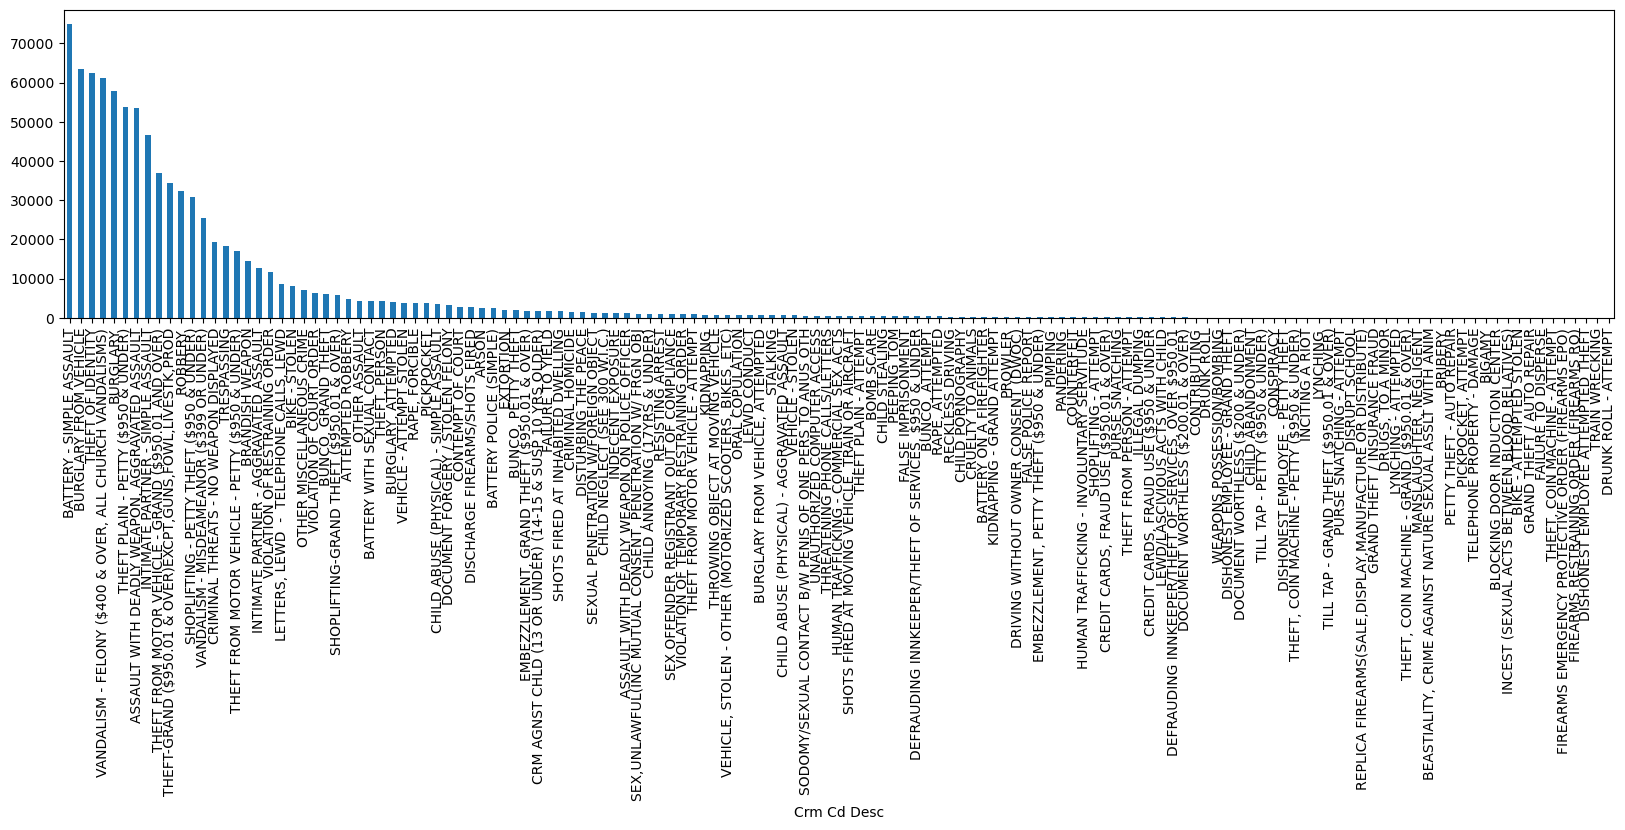

In [44]:
df['Crm Cd Desc'].value_counts().plot(kind='bar', figsize=(20, 4))

Modeling

Model 1 Classifier for Crime Type

  File "C:\Users\legom\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\legom\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\legom\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\legom\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Random Forest Classification Report for Crime Type (after SMOTE):
              precision    recall  f1-score   support

           2       0.54      0.68      0.60     10703
           4       0.63      0.75      0.68     14968
          11       0.14      0.48      0.21      1639
          14       0.44      0.42      0.43      2905
          17       0.61      0.68      0.64      1235
          19       0.56      0.50      0.53     11561
          20       0.47      0.49      0.48     12700
          37       0.51      0.35      0.41      3857
          72       0.55      0.70      0.62      2531
          73       0.75      0.69      0.72      9342
          76       0.55      0.49      0.52      1742
          84       0.27      0.25      0.26      1392
          99       0.40      0.25      0.31      6459
         104       0.65      0.79      0.71      6178
         105       0.21      0.32      0.26      1159
         112       0.42      0.37      0.39      7386
         113   

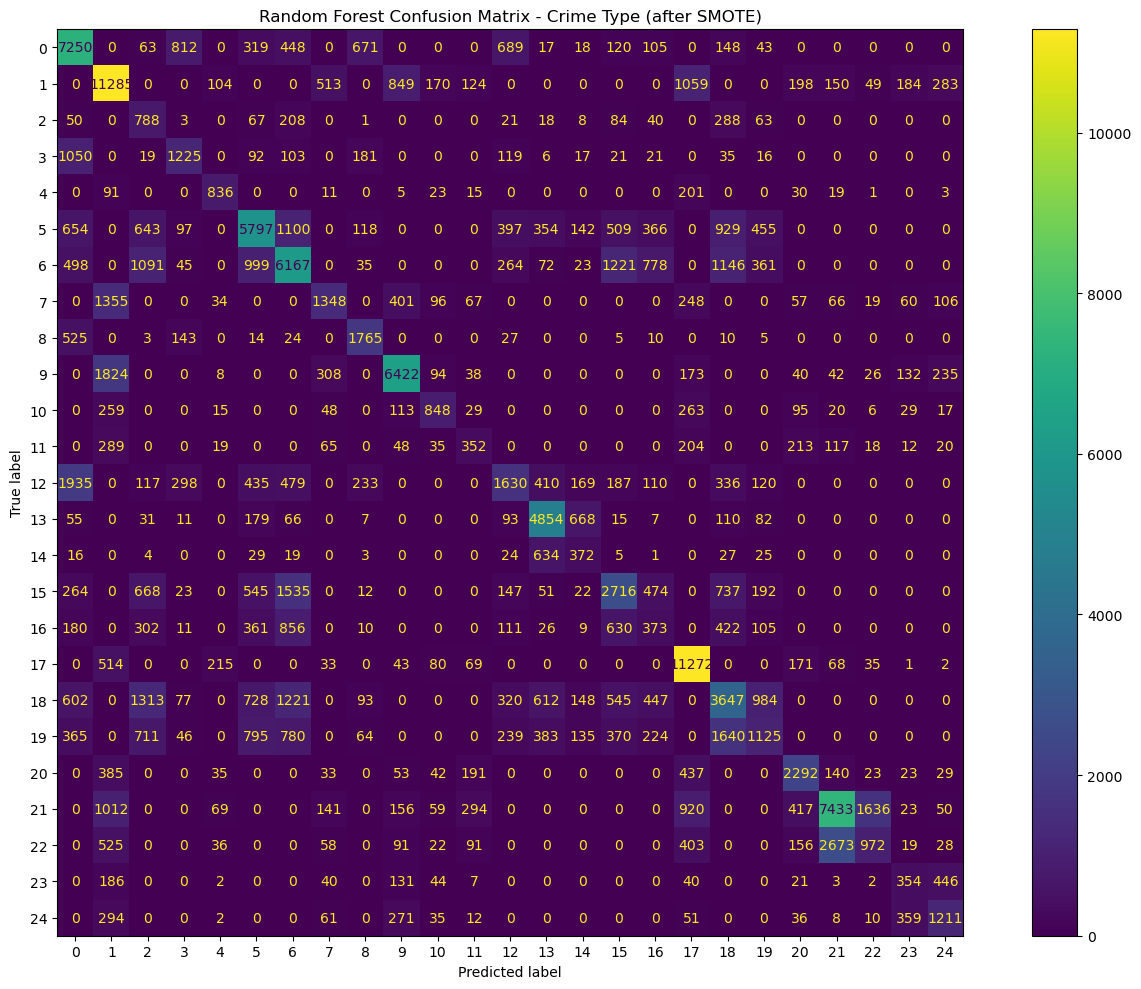

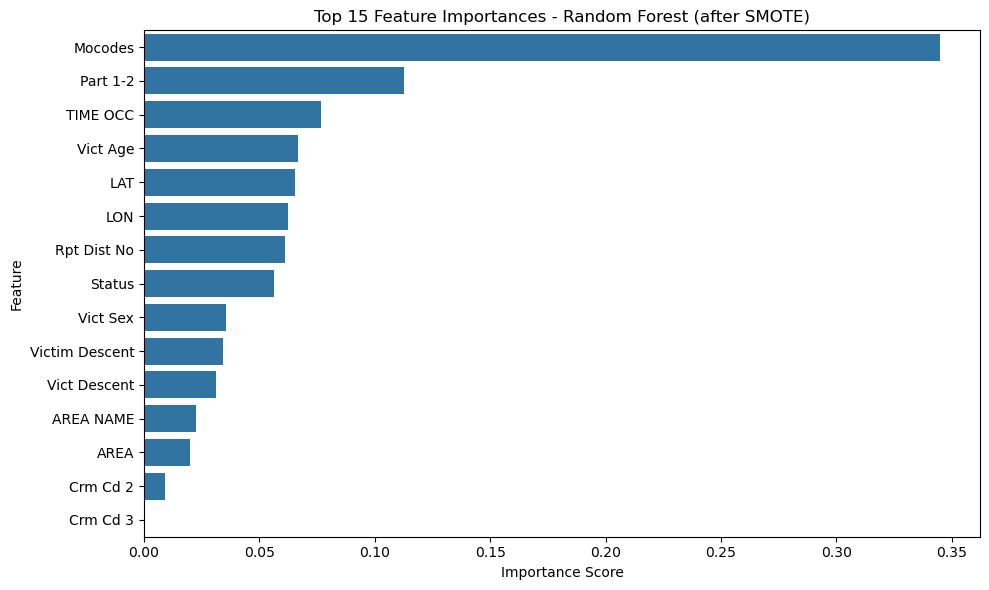

In [51]:
# Step 1: Copy and Prepare Dataset
df_crimetype = df.copy()

# Step 2: Keep only valid classes (>= 5000 samples)
class_counts = df_crimetype['Crime Type'].value_counts()
valid_classes = class_counts[class_counts >= 5000].index
df_crimetype = df_crimetype[df_crimetype['Crime Type'].isin(valid_classes)]

# Step 3: Drop unnecessary columns
cols_to_drop = ['DR_NO', 'Date Rptd', 'DATE OCC', 'LOCATION', 
                'Crm Cd', 'MO Description', 'Status Desc', 'Crm Cd Desc']
df_crimetype.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Step 4: Separate features and target
X = df_crimetype.drop(columns=['Crime Type'])
y = df_crimetype['Crime Type']

# Step 5: Label Encode object columns
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 7: Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 8: Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100, max_depth=20, random_state=42
)
rf.fit(X_train_resampled, y_train_resampled)

# Step 9: Predictions and Evaluation
y_pred = rf.predict(X_test)
print("Random Forest Classification Report for Crime Type (after SMOTE):")
print(classification_report(y_test, y_pred))

# Step 10: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(14, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.title('Random Forest Confusion Matrix - Crime Type (after SMOTE)')
plt.tight_layout()
plt.show()

# Step 11: Feature Importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title("Top 15 Feature Importances - Random Forest (after SMOTE)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

XGBoost Classification Report for Crime Type (after SMOTE):
              precision    recall  f1-score   support

           0       0.58      0.68      0.63     10703
           1       0.69      0.76      0.73     14968
           2       0.14      0.48      0.22      1639
           3       0.46      0.46      0.46      2905
           4       0.59      0.75      0.66      1235
           5       0.59      0.54      0.57     11561
           6       0.52      0.50      0.51     12700
           7       0.65      0.44      0.52      3857
           8       0.59      0.75      0.66      2531
           9       0.76      0.74      0.75      9342
          10       0.54      0.51      0.52      1742
          11       0.25      0.28      0.27      1392
          12       0.43      0.29      0.35      6459
          13       0.65      0.77      0.70      6178
          14       0.20      0.35      0.25      1159
          15       0.44      0.39      0.42      7386
          16       0.

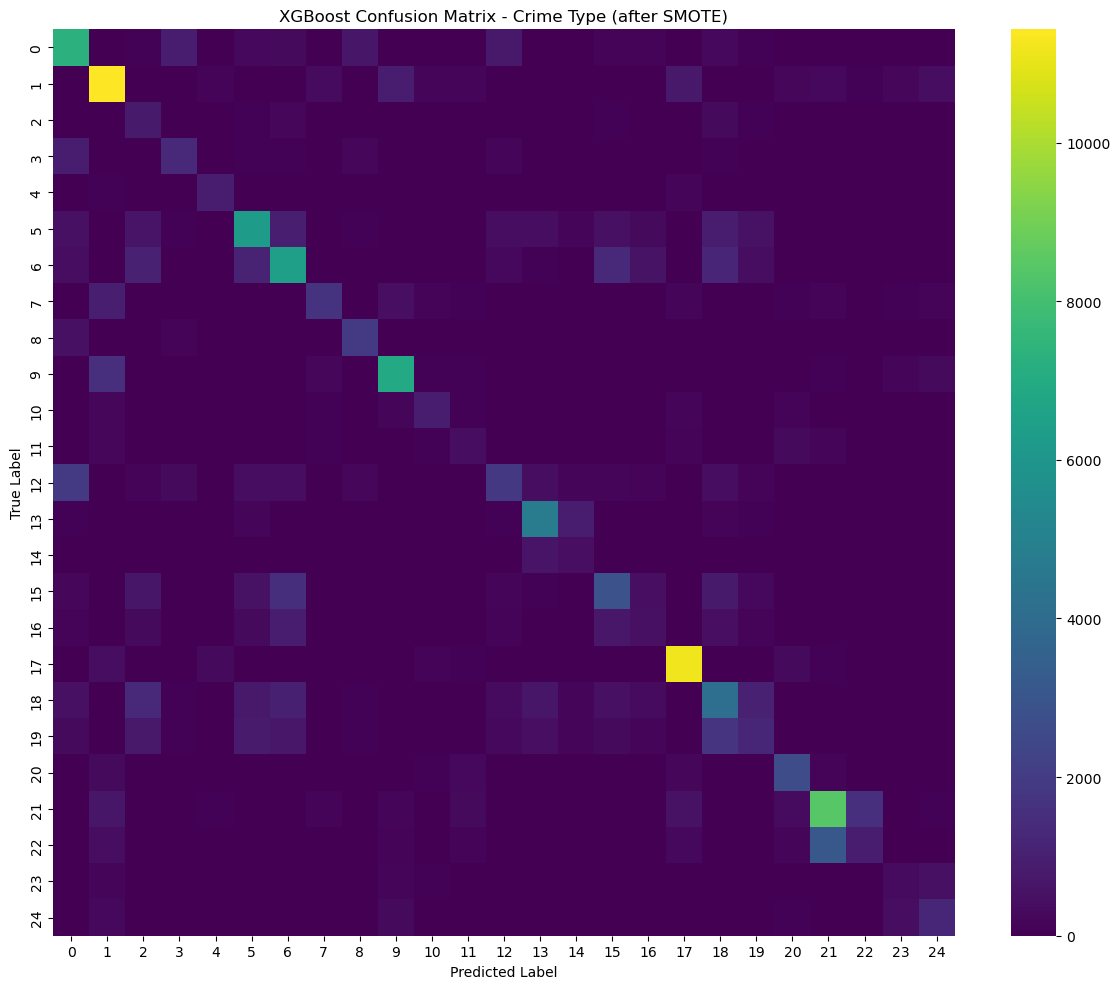

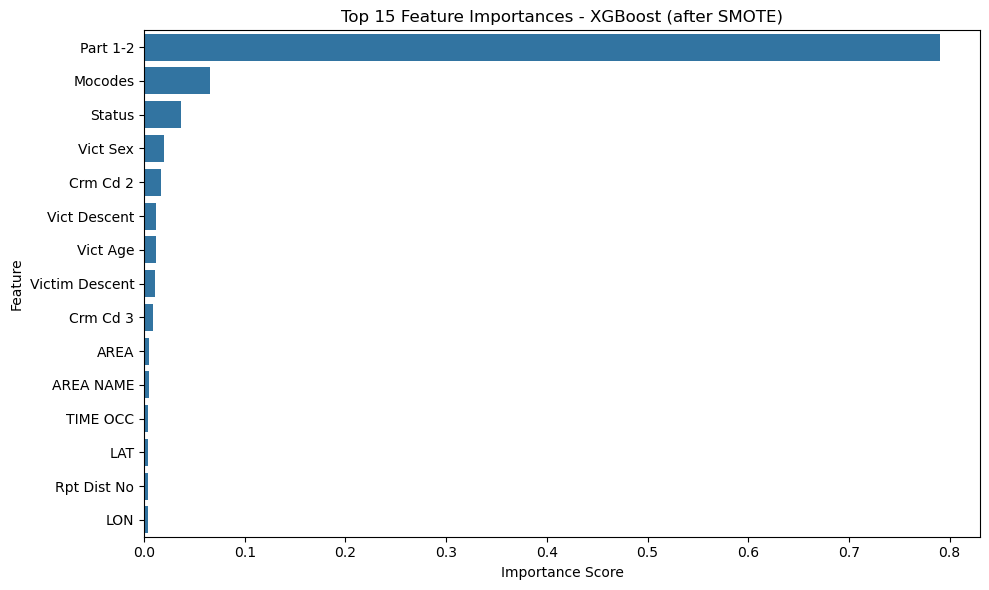

In [53]:
from xgboost import XGBClassifier

# Step 1: Encode labels
y_le = LabelEncoder()
y_train_enc = y_le.fit_transform(y_train)
y_test_enc = y_le.transform(y_test)

# Step 2: Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_enc_balanced = smote.fit_resample(X_train, y_train_enc)

# Step 3: Fit model on balanced data
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y_le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train_balanced, y_train_enc_balanced)

# Step 4: Predictions and evaluation (on the real imbalanced test set!)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Classification Report for Crime Type (after SMOTE):")
print(classification_report(y_test_enc, y_pred_xgb))

# Step 5: Confusion matrix
cm_xgb = confusion_matrix(y_test_enc, y_pred_xgb)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm_xgb, annot=False, fmt='d', cmap='viridis')
plt.title("XGBoost Confusion Matrix - Crime Type (after SMOTE)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Step 6: Feature Importances
importances_xgb = pd.Series(xgb.feature_importances_, index=X_train.columns)
top_feats_xgb = importances_xgb.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_feats_xgb, y=top_feats_xgb.index)
plt.title("Top 15 Feature Importances - XGBoost (after SMOTE)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Model 2 Status Modeling

Random Forest Classification Report for Status (after SMOTE):
              precision    recall  f1-score   support

           0       0.25      0.28      0.27     16414
           1       0.35      0.47      0.40     21305
           2       0.00      0.00      0.00         1
           3       0.88      0.76      0.82    133353
           4       0.03      0.24      0.05       615
           5       0.04      0.42      0.07       366

    accuracy                           0.68    172054
   macro avg       0.26      0.36      0.27    172054
weighted avg       0.75      0.68      0.71    172054



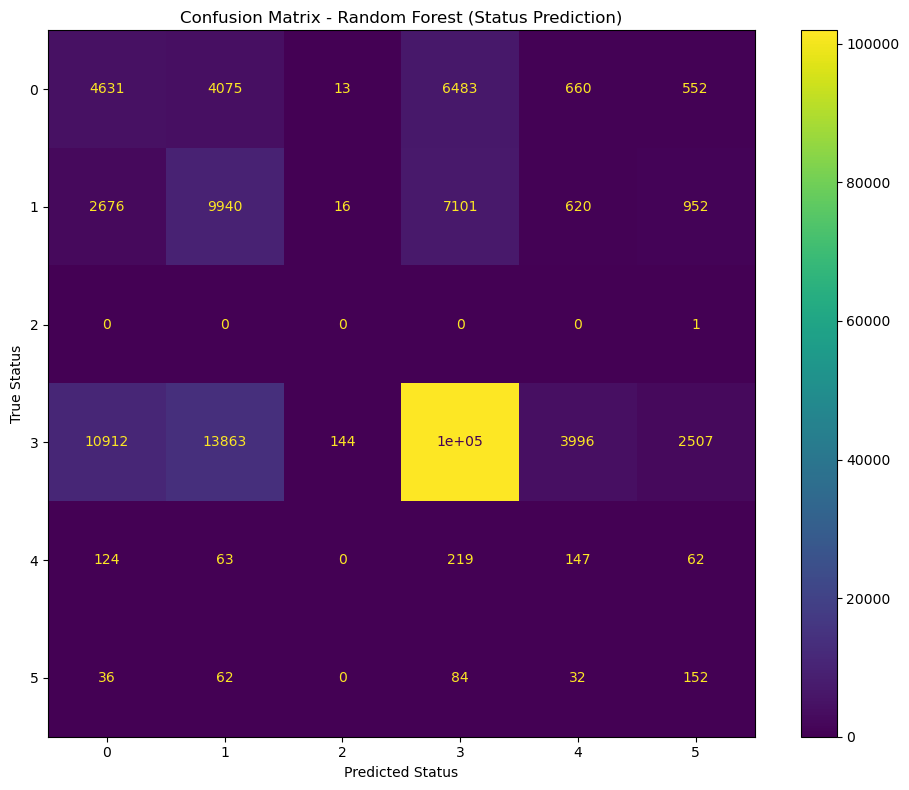

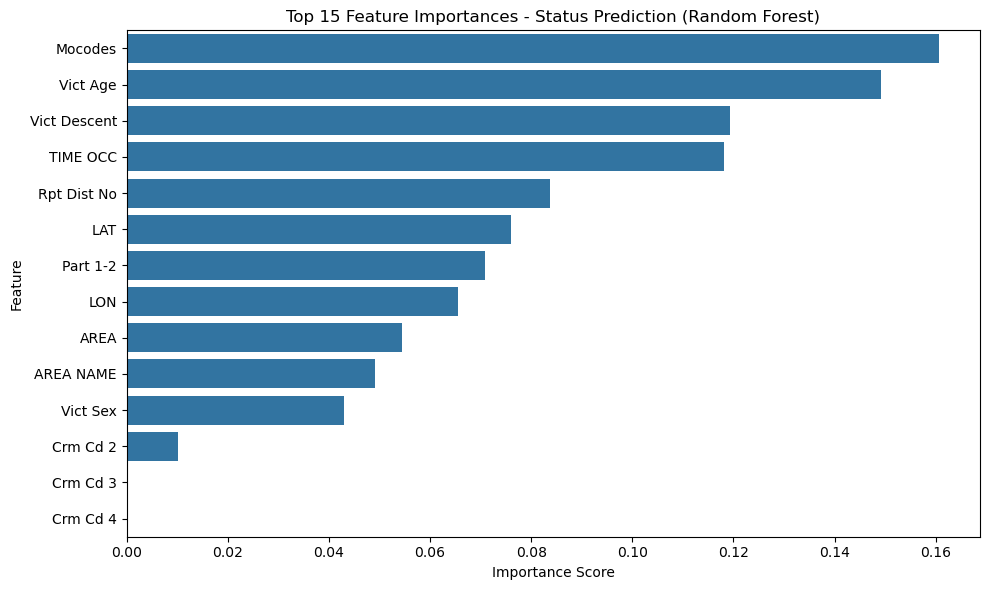

In [55]:
# 1. Copy dataset
df_status = df.copy()

# 2. Drop unnecessary columns
cols_to_drop = ['DR_NO', 'Date Rptd', 'DATE OCC', 'LOCATION', 'Cross Street',
                'Crm Cd', 'Crm Cd Desc', 'MO Description', 'Victim Descent', 'Crime Type', 'Status Desc']
df_status.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 3. Label Encode categorical features
cat_cols = df_status.select_dtypes(include='object').columns.tolist()
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df_status[col] = le.fit_transform(df_status[col])
    le_dict[col] = le

# 4. Separate X and y
X = df_status.drop(columns=['Status'])
y = df_status['Status']

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Apply SMOTE to training data
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=2, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# 7. Fit Random Forest on balanced data
rf_status = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
rf_status.fit(X_train_balanced, y_train_balanced)

# 8. Evaluate on test set
y_pred = rf_status.predict(X_test)
print("Random Forest Classification Report for Status (after SMOTE):")
print(classification_report(y_test, y_pred))

cm_status = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_status)
disp.plot(ax=ax)
plt.title("Confusion Matrix - Random Forest (Status Prediction)")
plt.xlabel("Predicted Status")
plt.ylabel("True Status")
plt.tight_layout()
plt.show()

importances_status = pd.Series(rf_status.feature_importances_, index=X_train.columns)
top_status_feats = importances_status.sort_values(ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_status_feats, y=top_status_feats.index)
plt.title("Top 15 Feature Importances - Status Prediction (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

XGBoost Classification Report for Status (after SMOTE):
              precision    recall  f1-score   support

           0       0.32      0.27      0.29     16414
           1       0.40      0.47      0.43     21305
           2       0.00      0.00      0.00         1
           3       0.87      0.86      0.87    133353
           4       0.08      0.11      0.09       615
           5       0.07      0.19      0.10       366

    accuracy                           0.75    172054
   macro avg       0.29      0.32      0.30    172054
weighted avg       0.76      0.75      0.75    172054



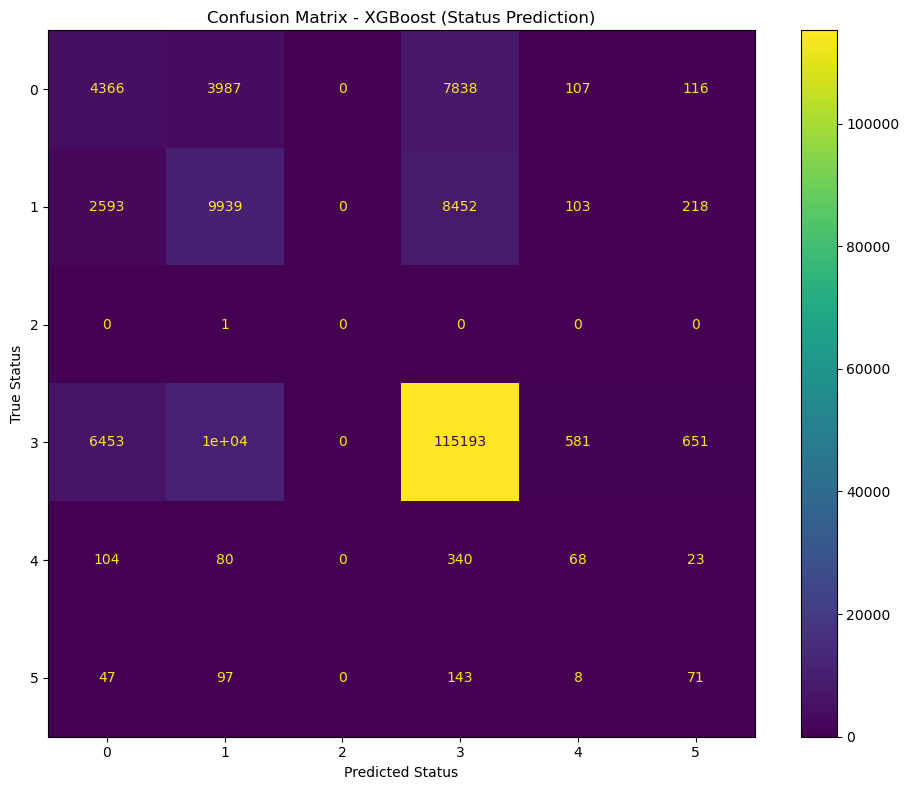

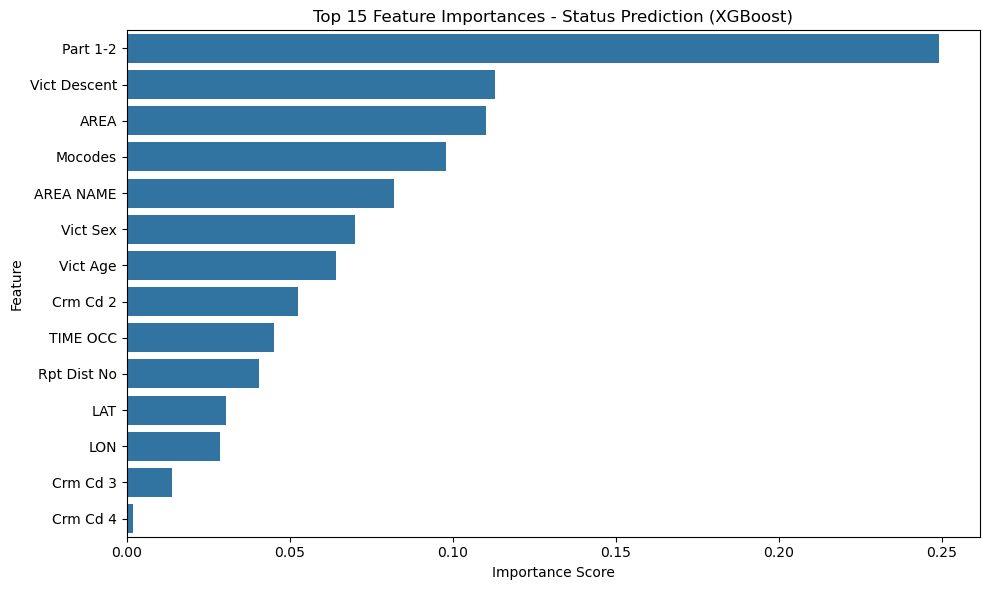

In [56]:
# 1. Apply SMOTE to training data
smote = SMOTE(k_neighbors=2, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# 2. Initialize XGBoost model
xgb_status = XGBClassifier(
    objective='multi:softmax',
    num_class=y.nunique(),
    max_depth=15,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

# 3. Fit on balanced data
xgb_status.fit(X_train_balanced, y_train_balanced)

# 4. Predictions and Evaluation
y_pred_xgb_status = xgb_status.predict(X_test)

print("XGBoost Classification Report for Status (after SMOTE):")
print(classification_report(y_test, y_pred_xgb_status))

cm_xgb_status = confusion_matrix(y_test, y_pred_xgb_status)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_status)
disp.plot(ax=ax)
plt.title("Confusion Matrix - XGBoost (Status Prediction)")
plt.xlabel("Predicted Status")
plt.ylabel("True Status")
plt.tight_layout()
plt.show()

xgb_importances = pd.Series(xgb_status.feature_importances_, index=X_train.columns)
top_xgb_feats = xgb_importances.sort_values(ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_xgb_feats, y=top_xgb_feats.index)
plt.title("Top 15 Feature Importances - Status Prediction (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Model 3: Victim Sex

Random Forest Classification Report for Vict Sex:
              precision    recall  f1-score   support

           1       0.62      0.58      0.60     71716
           2       0.00      0.00      0.00        23
           3       0.63      0.66      0.64     80777
           5       0.86      0.89      0.88     19537

    accuracy                           0.65    172053
   macro avg       0.53      0.53      0.53    172053
weighted avg       0.65      0.65      0.65    172053



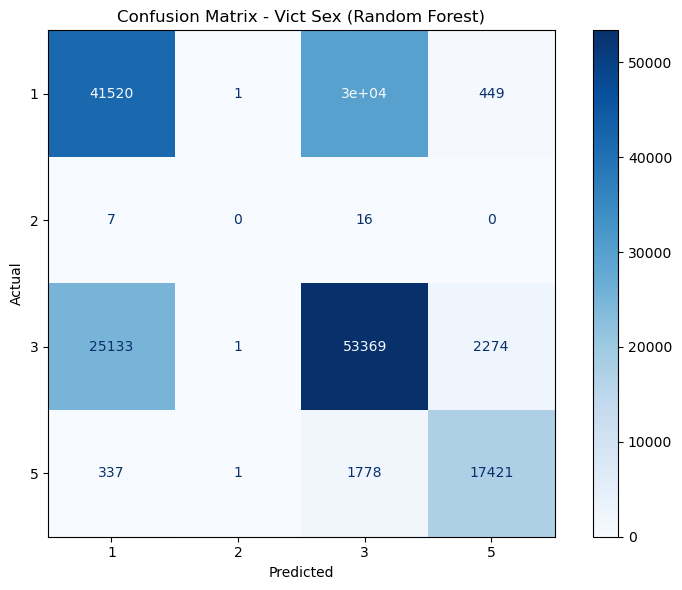

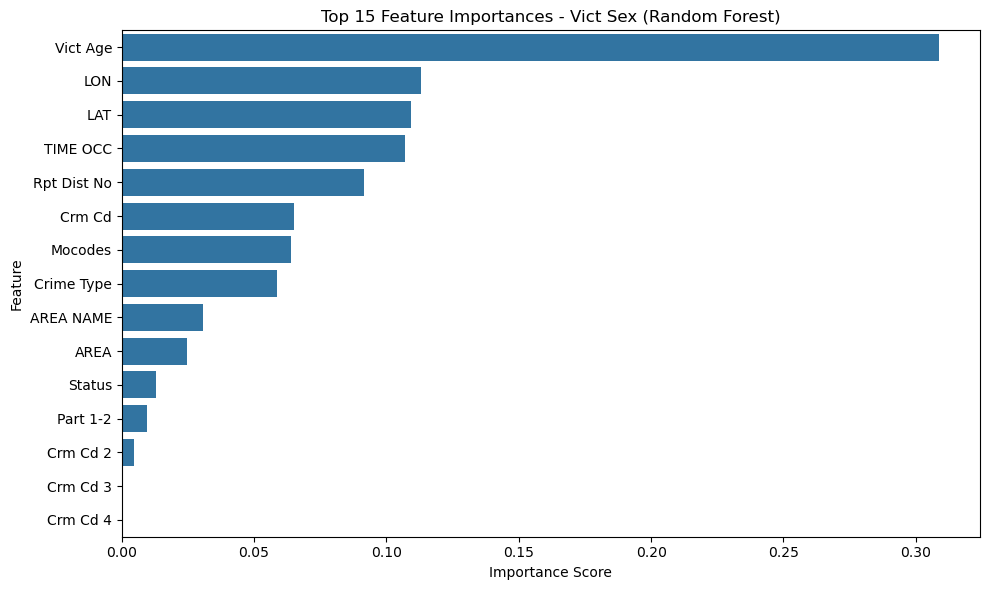

In [58]:
df_victsex = df.copy()

vc = df_victsex['Vict Sex'].value_counts()
valid_labels = vc[vc >= 100].index
df_victsex = df_victsex[df_victsex['Vict Sex'].isin(valid_labels)]

cols_to_drop = ['DR_NO', 'Date Rptd', 'DATE OCC', 'LOCATION', 'Crm Cd Desc', 
                'MO Description', 'Vict Descent', 'Victim Descent', 'Status Desc']
df_victsex.drop(columns=cols_to_drop, inplace=True, errors='ignore')

le_vsex = LabelEncoder()
df_victsex['Vict_Sex_Label'] = le_vsex.fit_transform(df_victsex['Vict Sex'])

X = df_victsex.drop(columns=['Vict Sex', 'Vict_Sex_Label'])
y = df_victsex['Vict_Sex_Label']

for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # ensure all values are strings

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf_vsex = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_vsex.fit(X_train, y_train)

y_pred_rf_vsex = rf_vsex.predict(X_test)

print("Random Forest Classification Report for Vict Sex:")
print(classification_report(
    y_test,
    y_pred_rf_vsex,
    target_names=[str(cls) for cls in le_vsex.classes_]
))

cm_vsex = confusion_matrix(y_test, y_pred_rf_vsex)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vsex, display_labels=le_vsex.classes_)
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix - Vict Sex (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

importances_vsex = pd.Series(rf_vsex.feature_importances_, index=X_train.columns)
top_feats_vsex = importances_vsex.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_feats_vsex, y=top_feats_vsex.index)
plt.title("Top 15 Feature Importances - Vict Sex (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

XGBoost Classification Report for Vict Sex (Balanced):
              precision    recall  f1-score   support

           1       0.61      0.57      0.59     71716
           2       0.00      0.13      0.00        23
           3       0.64      0.58      0.61     80777
           5       0.76      0.96      0.85     19537

    accuracy                           0.62    172053
   macro avg       0.50      0.56      0.51    172053
weighted avg       0.64      0.62      0.63    172053



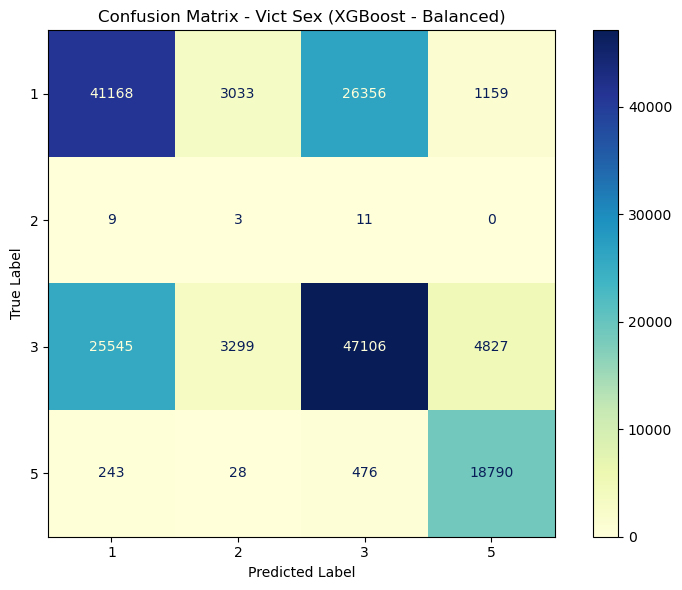

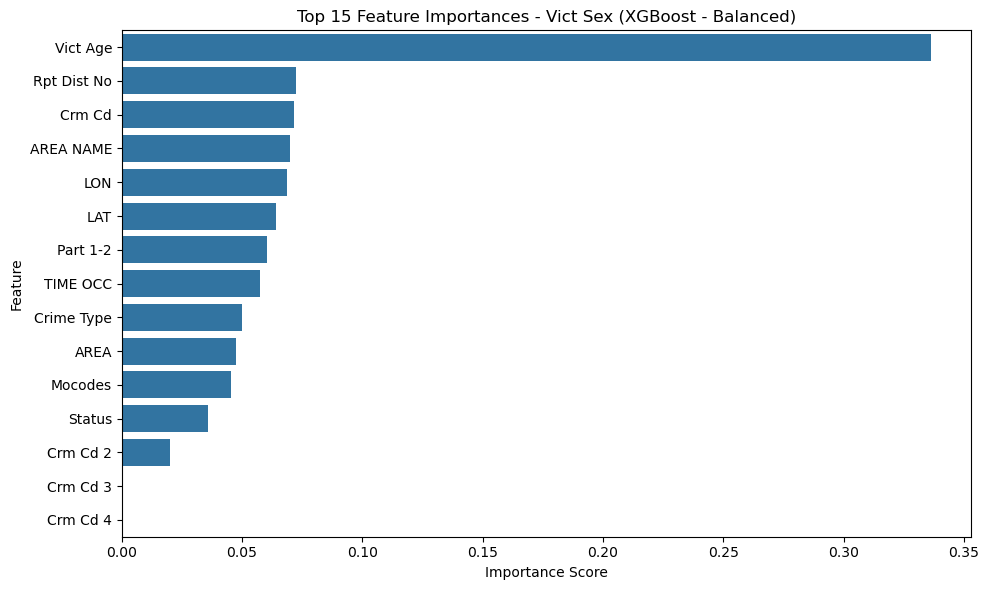

In [59]:
from imblearn.over_sampling import RandomOverSampler

# Apply RandomOverSampler to training set only
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

# Refit XGBoost on balanced training data
xgb_vsex_balanced = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train_bal)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_vsex_balanced.fit(X_train_bal, y_train_bal)

# Predict
y_pred_xgb_vsex_balanced = xgb_vsex_balanced.predict(X_test)

# Evaluate
print("XGBoost Classification Report for Vict Sex (Balanced):")
print(classification_report(
    y_test, y_pred_xgb_vsex_balanced, target_names=[str(cls) for cls in le_vsex.classes_]
))

cm_xgb_vsex_balanced = confusion_matrix(y_test, y_pred_xgb_vsex_balanced)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_vsex_balanced, display_labels=[str(cls) for cls in le_vsex.classes_])
disp.plot(ax=ax, cmap='YlGnBu')
plt.title("Confusion Matrix - Vict Sex (XGBoost - Balanced)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# 2. Feature Importances for Balanced XGBoost
importances = xgb_vsex_balanced.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(15))
plt.title("Top 15 Feature Importances - Vict Sex (XGBoost - Balanced)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Model 4: Ethnicity

Random Forest Classification Report (Balanced Training Data):

              precision    recall  f1-score   support

           1       0.13      0.13      0.13      4268
           2       0.46      0.45      0.46     27165
           3       0.07      0.13      0.09       926
           5       0.06      0.10      0.08       968
           7       0.62      0.61      0.61     59286
           8       0.03      0.03      0.03       203
           9       0.05      0.07      0.05       317
          10       0.12      0.26      0.17      1198
          12       0.27      0.20      0.23     15601
          13       0.06      0.03      0.04        58
          15       0.05      0.02      0.03        44
          16       0.05      0.05      0.05       239
          17       0.51      0.53      0.52     40286
          18       0.83      0.89      0.86     21320
          19       0.00      0.00      0.00       115

    accuracy                           0.54    171994
   macro avg     

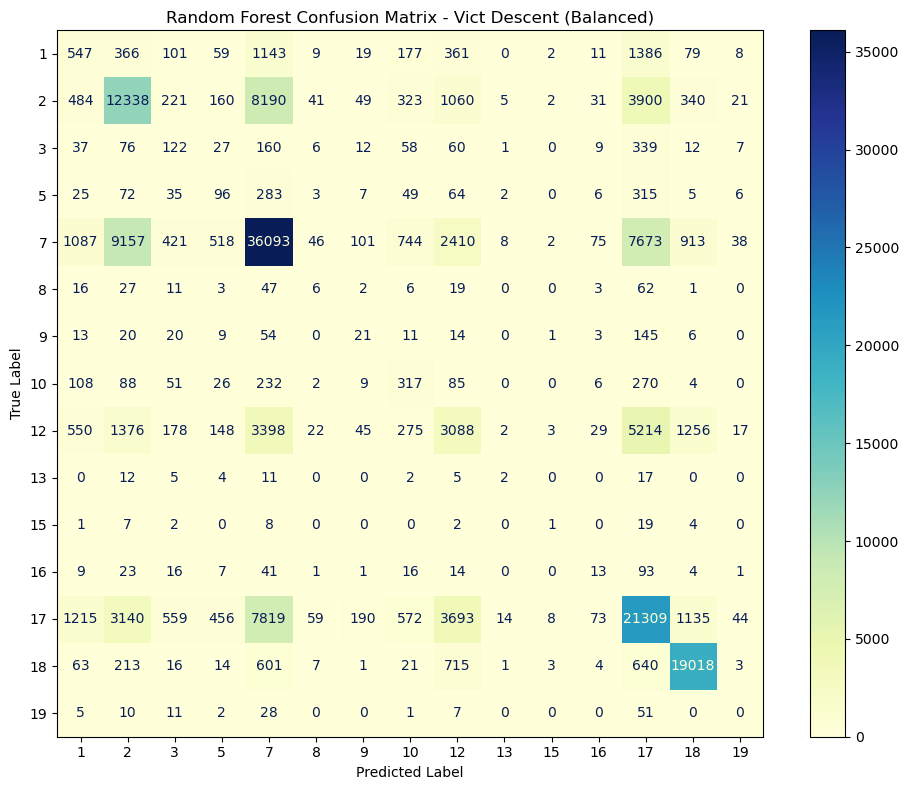

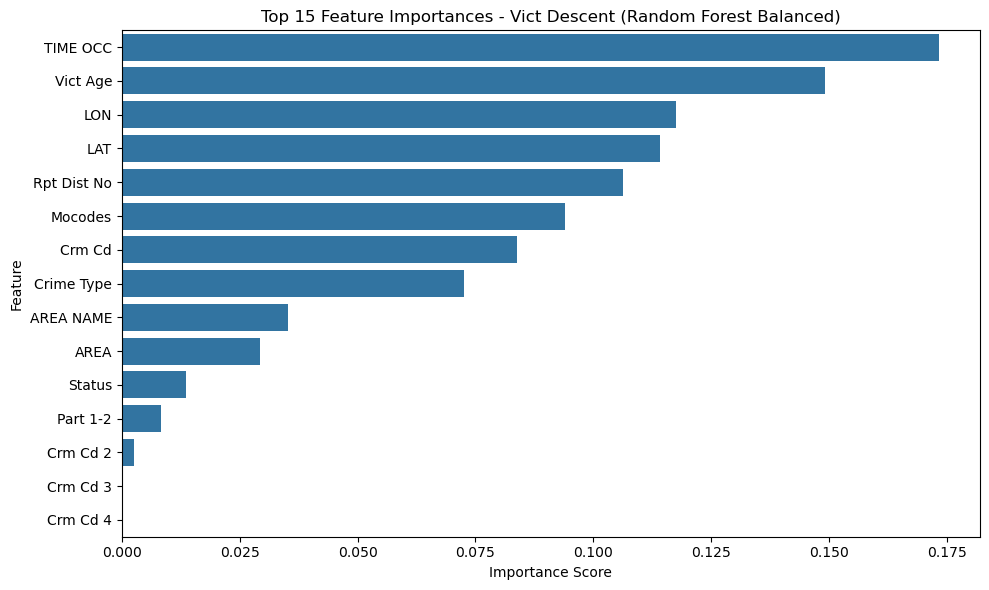

In [61]:
df_victdescent = df.copy()

vc = df_victdescent['Vict Descent'].value_counts()
valid_labels = vc[vc >= 100].index
df_victdescent = df_victdescent[df_victdescent['Vict Descent'].isin(valid_labels)]

cols_to_drop = ['DR_NO', 'Date Rptd', 'DATE OCC', 'LOCATION', 'Crm Cd Desc',
                'MO Description', 'Vict Sex', 'Victim Descent', 'Status Desc']
df_victdescent.drop(columns=cols_to_drop, inplace=True, errors='ignore')

le_vdesc = LabelEncoder()
df_victdescent['Vict_Descent_Label'] = le_vdesc.fit_transform(df_victdescent['Vict Descent'])

X = df_victdescent.drop(columns=['Vict Descent', 'Vict_Descent_Label'])
y = df_victdescent['Vict_Descent_Label']

for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# --- Random Forest (Balanced Data) ---
rf_bal = RandomForestClassifier(n_estimators=100, class_weight=None, random_state=42)
rf_bal.fit(X_train_bal, y_train_bal)

y_pred_rf_bal = rf_bal.predict(X_test)

print("Random Forest Classification Report (Balanced Training Data):\n")
print(classification_report(
    y_test, y_pred_rf_bal, target_names=[str(cls) for cls in le_vdesc.classes_]
))

# Confusion Matrix
cm_rf_bal = confusion_matrix(y_test, y_pred_rf_bal)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_bal, display_labels=[str(cls) for cls in le_vdesc.classes_])
disp.plot(ax=ax, cmap='YlGnBu')
plt.title("Random Forest Confusion Matrix - Vict Descent (Balanced)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Feature Importances
importances_rf_bal = rf_bal.feature_importances_
feat_importance_df_rf_bal = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances_rf_bal
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df_rf_bal.head(15))
plt.title("Top 15 Feature Importances - Vict Descent (Random Forest Balanced)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

XGBoost Classification Report - Victim Descent (Balanced Training Data):
              precision    recall  f1-score   support

           1       0.10      0.13      0.11      4268
           2       0.45      0.46      0.46     27165
           3       0.05      0.31      0.08       926
           5       0.03      0.27      0.06       968
           7       0.65      0.46      0.54     59286
           8       0.02      0.17      0.03       203
           9       0.02      0.21      0.03       317
          10       0.08      0.44      0.13      1198
          12       0.28      0.17      0.21     15601
          13       0.00      0.03      0.00        58
          15       0.00      0.20      0.01        44
          16       0.01      0.12      0.02       239
          17       0.54      0.36      0.43     40286
          18       0.81      0.91      0.86     21320
          19       0.01      0.23      0.01       115

    accuracy                           0.45    171994
   macr

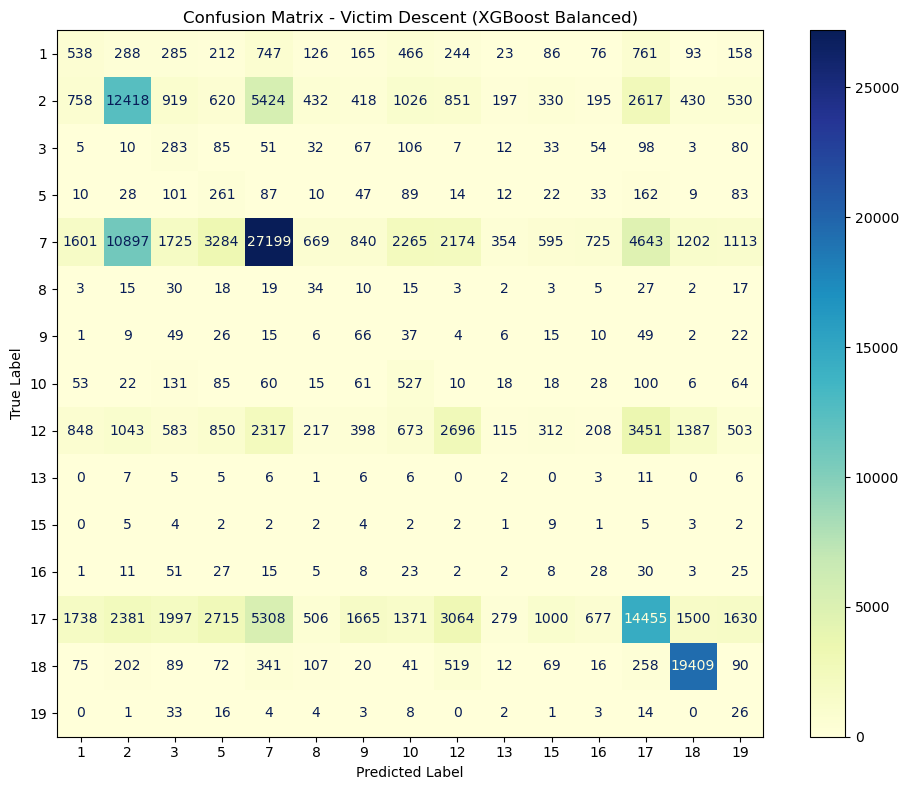

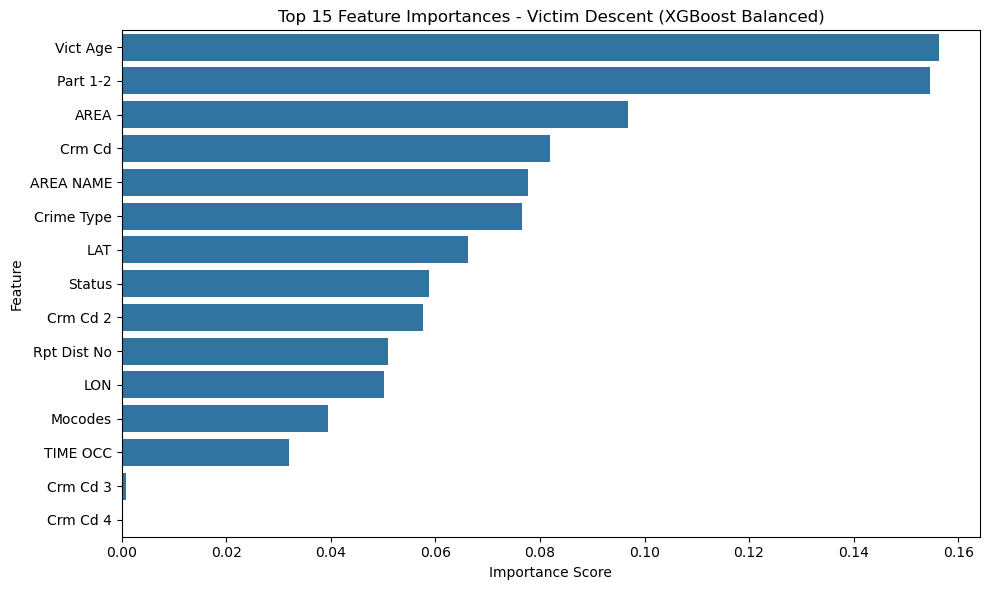

In [62]:
# Apply SMOTE to balance Vict Descent classes
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal_xgb, y_train_bal_xgb = smote.fit_resample(X_train, y_train)

# Train XGBoost on balanced training data
xgb_vdesc = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train_bal_xgb)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_vdesc.fit(X_train_bal_xgb, y_train_bal_xgb)

# Predictions and evaluation
y_pred_xgb_vdesc = xgb_vdesc.predict(X_test)

print("XGBoost Classification Report - Victim Descent (Balanced Training Data):")
print(classification_report(
    y_test,
    y_pred_xgb_vdesc,
    target_names=[str(cls) for cls in le_vdesc.classes_]
))

# Confusion Matrix
cm_xgb_vdesc = confusion_matrix(y_test, y_pred_xgb_vdesc)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_vdesc, display_labels=[str(cls) for cls in le_vdesc.classes_])
disp.plot(ax=ax, cmap='YlGnBu')
plt.title("Confusion Matrix - Victim Descent (XGBoost Balanced)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Feature Importances
importances_xgb_vdesc = xgb_vdesc.feature_importances_
feat_importance_df_vdesc = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances_xgb_vdesc
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df_vdesc.head(15))
plt.title("Top 15 Feature Importances - Victim Descent (XGBoost Balanced)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Geospatial Modeling

Hotspot detection

In [65]:
df['AREA NAME'].unique()

array([20,  1, 15, 17, 13,  5,  6, 10, 19,  4,  0, 18,  9,  8, 12,  7, 14,
       11,  2, 16,  3], dtype=int64)

Classification Report for Crime Type (Geospatial Only, SMOTE applied):
              precision    recall  f1-score   support

           2       0.17      0.16      0.16     10699
           4       0.20      0.12      0.15     14896
          11       0.09      0.24      0.13      1636
          14       0.05      0.07      0.06      2897
          17       0.03      0.04      0.03      1235
          19       0.24      0.22      0.23     11558
          20       0.25      0.24      0.25     12689
          37       0.07      0.08      0.07      3856
          72       0.05      0.07      0.06      2530
          73       0.14      0.13      0.13      9297
          76       0.04      0.05      0.04      1739
          84       0.04      0.05      0.04      1376
          99       0.11      0.14      0.13      6458
         104       0.44      0.59      0.50      6157
         105       0.11      0.53      0.18      1159
         112       0.14      0.13      0.13      7380
         1

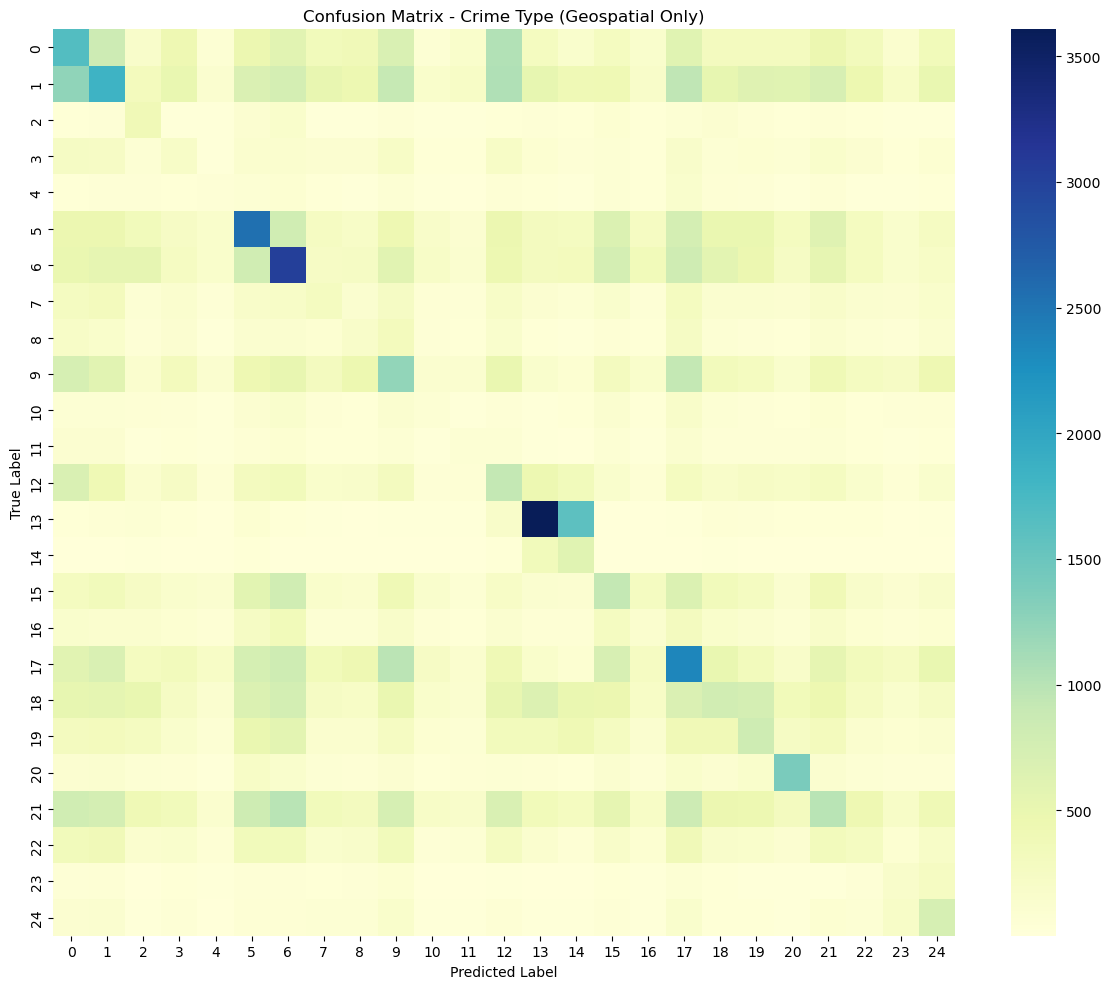

In [66]:
# Copy and clean the dataframe
df_geo = df.copy()
df_geo = df_geo[(df_geo['LAT'] != 0) & (df_geo['LON'] != 0)].dropna(subset=['LAT', 'LON', 'Crime Type'])

# Keep only crime types with >= 5000 samples
vc = df_geo['Crime Type'].value_counts()
valid_types = vc[vc >= 5000].index
df_geo = df_geo[df_geo['Crime Type'].isin(valid_types)]

# Encode target
le = LabelEncoder()
df_geo['Crime_Label'] = le.fit_transform(df_geo['Crime Type'])

# Features: Latitude and Longitude
X = df_geo[['LAT', 'LON']]
y = df_geo['Crime_Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Balance training set using SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Train Random Forest on balanced data
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight=None,   # No need for 'balanced' after SMOTE
    random_state=42
)
clf.fit(X_train_bal, y_train_bal)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print("Classification Report for Crime Type (Geospatial Only, SMOTE applied):")
print(classification_report(y_test, y_pred, target_names=[str(label) for label in le.classes_]))

# Confusion Matrix
cm_geo = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm_geo, cmap='YlGnBu', annot=False)
plt.title("Confusion Matrix - Crime Type (Geospatial Only)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

XGBoost Classification Report (Geospatial Only, SMOTE applied):
              precision    recall  f1-score   support

           2       0.13      0.07      0.09     10699
           4       0.16      0.01      0.02     14896
          11       0.04      0.44      0.07      1636
          14       0.03      0.03      0.03      2897
          17       0.01      0.06      0.02      1235
          19       0.16      0.08      0.10     11558
          20       0.19      0.15      0.16     12689
          37       0.04      0.01      0.02      3856
          72       0.03      0.14      0.05      2530
          73       0.09      0.02      0.03      9297
          76       0.02      0.05      0.03      1739
          84       0.01      0.03      0.02      1376
          99       0.10      0.13      0.12      6458
         104       0.20      0.37      0.26      6157
         105       0.04      0.42      0.08      1159
         112       0.08      0.06      0.07      7380
         113     

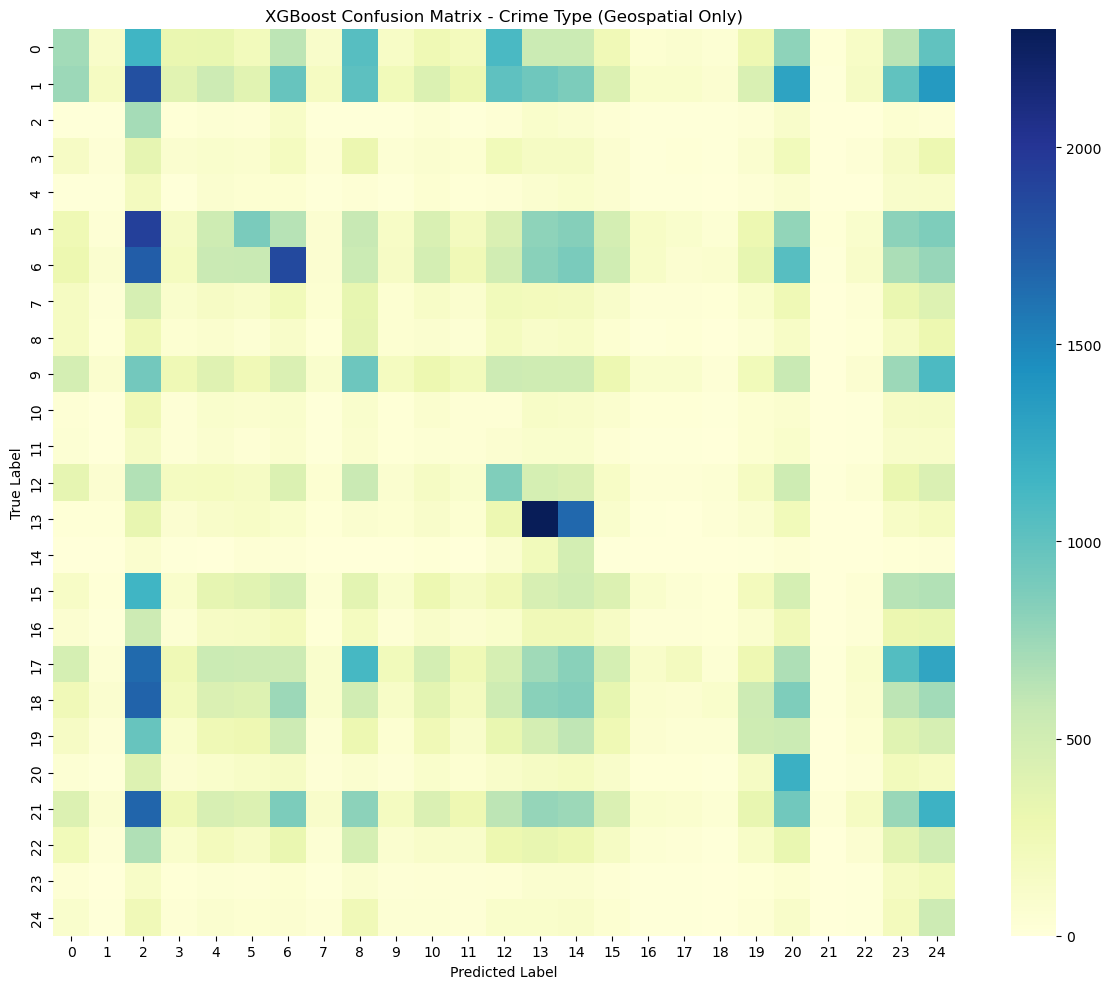

In [67]:
# XGBoost Model
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train_bal)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train on balanced data
xgb_model.fit(X_train_bal, y_train_bal)

# Predict on real test set
y_pred = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Classification Report (Geospatial Only, SMOTE applied):")
print(classification_report(y_test, y_pred, target_names=[str(label) for label in le.classes_]))

# Confusion Matrix
cm_xgb_geo = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm_xgb_geo, cmap='YlGnBu', annot=False)
plt.title("XGBoost Confusion Matrix - Crime Type (Geospatial Only)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

 XGBoost Classification Report (Geospatial + Temporal with SMOTE):
              precision    recall  f1-score   support

           2       0.17      0.12      0.14     13374
           4       0.17      0.06      0.09     18620
          11       0.05      0.41      0.09      2045
          14       0.03      0.04      0.03      3622
          17       0.03      0.32      0.05      1543
          19       0.22      0.14      0.17     14447
          20       0.25      0.21      0.23     15862
          37       0.04      0.01      0.02      4821
          72       0.04      0.11      0.06      3163
          73       0.13      0.09      0.10     11621
          76       0.03      0.02      0.02      2174
          84       0.02      0.02      0.02      1719
          99       0.10      0.10      0.10      8073
         104       0.27      0.52      0.36      7696
         105       0.02      0.28      0.05      1448
         112       0.14      0.09      0.11      9225
         113  

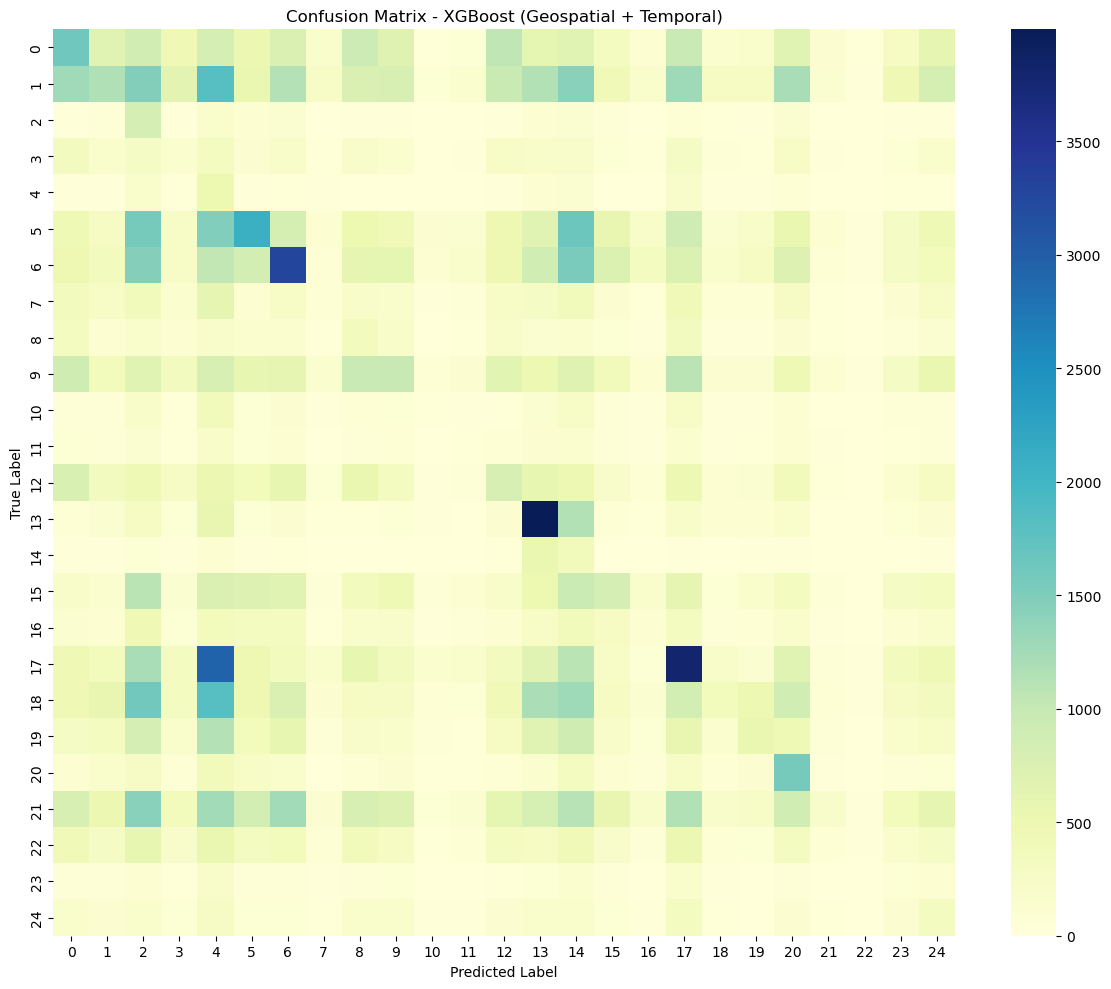

In [68]:
df_geo_temp = df.copy()
df_geo_temp['Crime Type'] = LabelEncoder().fit_transform(df_geo_temp['Crm Cd Desc'])
df_geo_temp = df_geo_temp[(df_geo_temp['LAT'] != 0) & (df_geo_temp['LON'] != 0)]
df_geo_temp = df_geo_temp.dropna(subset=['LAT', 'LON', 'Crime Type', 'TIME OCC', 'DATE OCC'])

# Filter to the most common crime types
vc = df_geo_temp['Crime Type'].value_counts()
valid_types = vc[vc >= 5000].index

# Convert time features
df_geo_temp['DATE OCC'] = pd.to_datetime(df_geo_temp['DATE OCC'], errors='coerce')
df_geo_temp['Hour'] = df_geo_temp['TIME OCC'] // 100
df_geo_temp['Month'] = df_geo_temp['DATE OCC'].dt.month
df_geo_temp['Weekday'] = df_geo_temp['DATE OCC'].dt.weekday
df_geo_temp = df_geo_temp.dropna(subset=['Month', 'Weekday'])

# Keep only valid crime types
df_geo_temp = df_geo_temp[df_geo_temp['Crime Type'].isin(valid_types)]

# Encode target
le = LabelEncoder()
df_geo_temp['Crime_Label'] = le.fit_transform(df_geo_temp['Crime Type'])

# Define features and target
X = df_geo_temp[['LAT', 'LON', 'Hour', 'Month', 'Weekday']]
y = df_geo_temp['Crime_Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Initialize and train XGBoost
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train_bal)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train_bal, y_train_bal)
y_pred = xgb.predict(X_test)

# Evaluation
print(" XGBoost Classification Report (Geospatial + Temporal with SMOTE):")
print(classification_report(y_test, y_pred, target_names=[str(label) for label in le.classes_]))

# Confusion Matrix
cm_xgb_geo_temp = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm_xgb_geo_temp, cmap='YlGnBu', annot=False)
plt.title("Confusion Matrix - XGBoost (Geospatial + Temporal)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [69]:
df_area_var = df.copy()

cols_to_use = ['AREA NAME', 'LAT', 'LON', 'DATE OCC', 'TIME OCC']
df = df.dropna(subset=['AREA NAME'])

le_area = LabelEncoder()
df['Area_Label'] = le_area.fit_transform(df['AREA NAME'])

print("Unique areas:", df['Area_Label'].nunique())
print(df[['AREA NAME', 'Area_Label']].drop_duplicates().head())                         

Unique areas: 21
   AREA NAME  Area_Label
0         20          20
1          1           1
2         15          15
3         17          17
6         13          13


XGBoost Classification Report (Predicting AREA NAME with SMOTE):
              precision    recall  f1-score   support

           0       0.12      0.22      0.16     10352
           1       0.15      0.25      0.19     12739
           2       0.07      0.07      0.07      7252
           3       0.04      0.04      0.04      5480
           4       0.07      0.06      0.06      6813
           5       0.05      0.08      0.06      5941
           6       0.11      0.07      0.09      9474
           7       0.07      0.07      0.07      6567
           8       0.16      0.03      0.05      8837
           9       0.07      0.04      0.05      7923
          10       0.07      0.08      0.08      7258
          11       0.08      0.01      0.02      8584
          12       0.11      0.23      0.15     10052
          13       0.07      0.03      0.04      7979
          14       0.09      0.22      0.12      8260
          15       0.13      0.03      0.04      9737
          16    

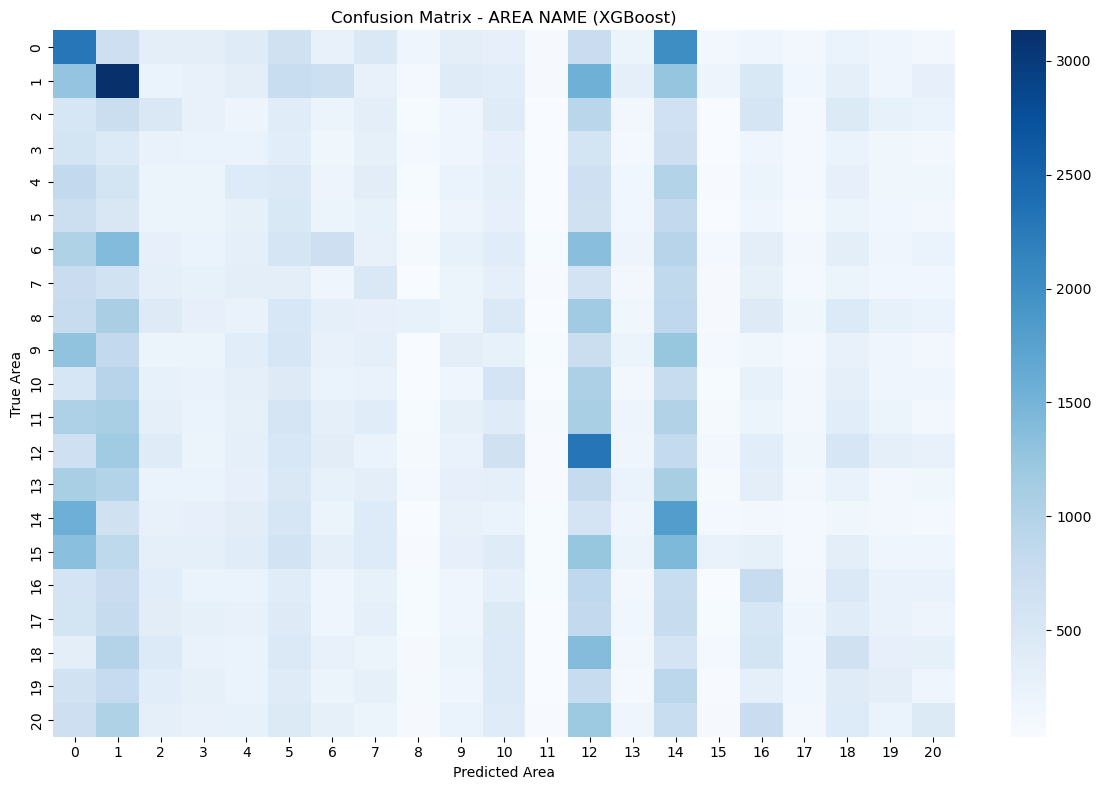

In [71]:
# Ensure DATE OCC is datetime
df_area_var['DATE OCC'] = pd.to_datetime(df_area_var['DATE OCC'], errors='coerce')

# Temporal features
df_area_var['Hour'] = df_area_var['TIME OCC'] // 100
df_area_var['Month'] = df_area_var['DATE OCC'].dt.month
df_area_var['Weekday'] = df_area_var['DATE OCC'].dt.weekday

# Drop missing temporal features
df_area_var = df_area_var.dropna(subset=['Crime Type', 'Hour', 'Month', 'Weekday'])

# Encode AREA NAME (target)
le_area = LabelEncoder()
df_area_var['Area_Label'] = le_area.fit_transform(df_area_var['AREA NAME'])

# Encode Crime Type (feature)
le_crime = LabelEncoder()
df_area_var['Crime_Label'] = le_crime.fit_transform(df_area_var['Crime Type'])

# Define predictors and target
X = df_area_var[['Crime_Label', 'Hour', 'Month', 'Weekday']]
y = df_area_var['Area_Label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Apply SMOTE to handle area imbalance
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Train XGBoost on the balanced training set
xgb_area = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_area.fit(X_train_bal, y_train_bal)

# Predict and evaluate
y_pred = xgb_area.predict(X_test)

print("XGBoost Classification Report (Predicting AREA NAME with SMOTE):")
print(classification_report(
    y_test, y_pred, target_names=[str(cls) for cls in le_area.classes_]
))

#Confusion Matrix
cm_area = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm_area, cmap='Blues', annot=False)
plt.title('Confusion Matrix - AREA NAME (XGBoost)')
plt.xlabel('Predicted Area')
plt.ylabel('True Area')
plt.tight_layout()
plt.show()

XGBoost Classification Report with SMOTE (Predicting AREA NAME):
              precision    recall  f1-score   support

           0       0.12      0.22      0.16     10352
           1       0.15      0.25      0.19     12739
           2       0.07      0.07      0.07      7252
           3       0.04      0.04      0.04      5480
           4       0.07      0.06      0.06      6813
           5       0.05      0.08      0.06      5941
           6       0.11      0.07      0.09      9474
           7       0.07      0.07      0.07      6567
           8       0.16      0.03      0.05      8837
           9       0.07      0.04      0.05      7923
          10       0.07      0.08      0.08      7258
          11       0.08      0.01      0.02      8584
          12       0.11      0.23      0.15     10052
          13       0.07      0.03      0.04      7979
          14       0.09      0.22      0.12      8260
          15       0.13      0.03      0.04      9737
          16    

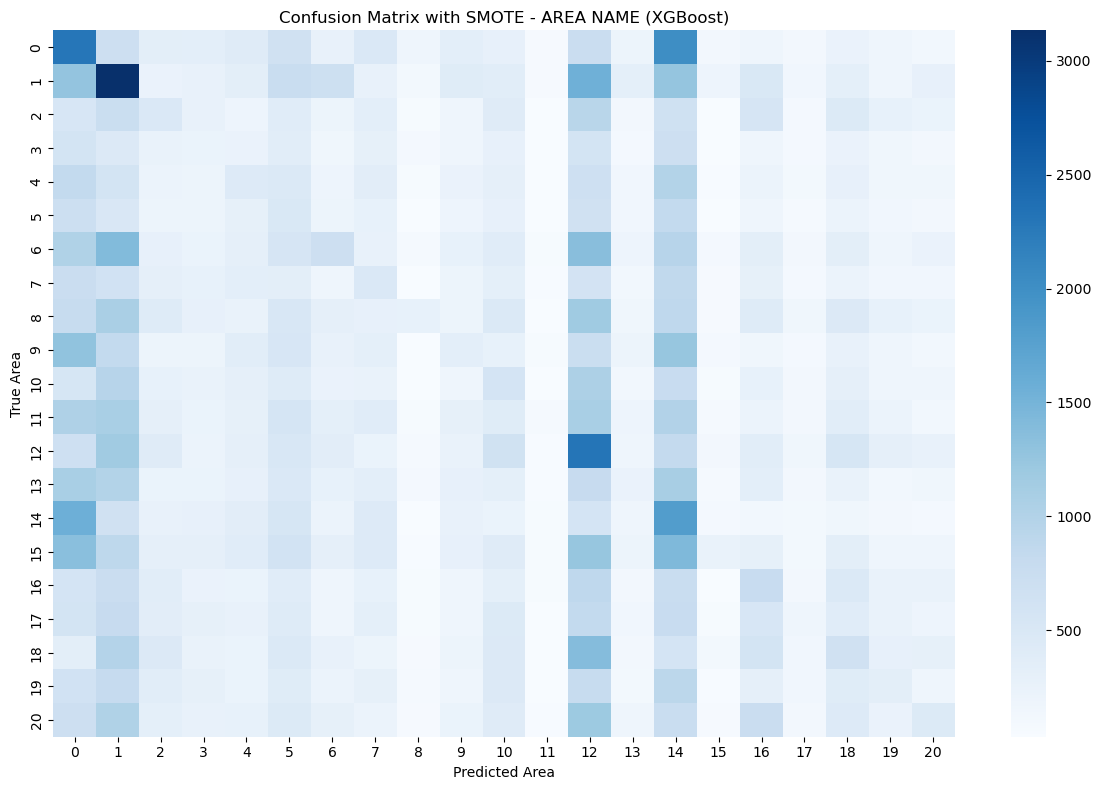

In [72]:
# Encode all object-type features
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Apply SMOTE to training data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Train XGBoost
xgb_area = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le_area.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_area.fit(X_res, y_res)

# Predict and evaluate
y_pred = xgb_area.predict(X_test)

print("XGBoost Classification Report with SMOTE (Predicting AREA NAME):")
print(classification_report(
    y_test, y_pred, target_names=[str(cls) for cls in le_area.classes_]
))

cm_area = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm_area, cmap='Blues', annot=False)
plt.title('Confusion Matrix with SMOTE - AREA NAME (XGBoost)')
plt.xlabel('Predicted Area')
plt.ylabel('True Area')
plt.tight_layout()
plt.show()

XGBoost Classification Report (Crime Type with AREA feature, Weighted):
              precision    recall  f1-score   support

           0       0.03      0.05      0.03       513
           1       0.07      0.35      0.12       216
           2       0.31      0.01      0.02     10703
           3       0.02      0.02      0.02       967
           4       0.39      0.01      0.02     14968
           5       0.00      0.16      0.01        51
           6       0.07      0.16      0.10       513
           7       0.02      0.03      0.03       833
          11       0.05      0.13      0.08      1639
          13       0.01      0.18      0.02        94
          14       0.29      0.11      0.16      2905
          16       0.00      0.12      0.00        65
          17       0.05      0.12      0.07      1235
          18       0.01      0.05      0.01       405
          19       0.44      0.03      0.05     11561
          20       0.32      0.11      0.16     12700
         

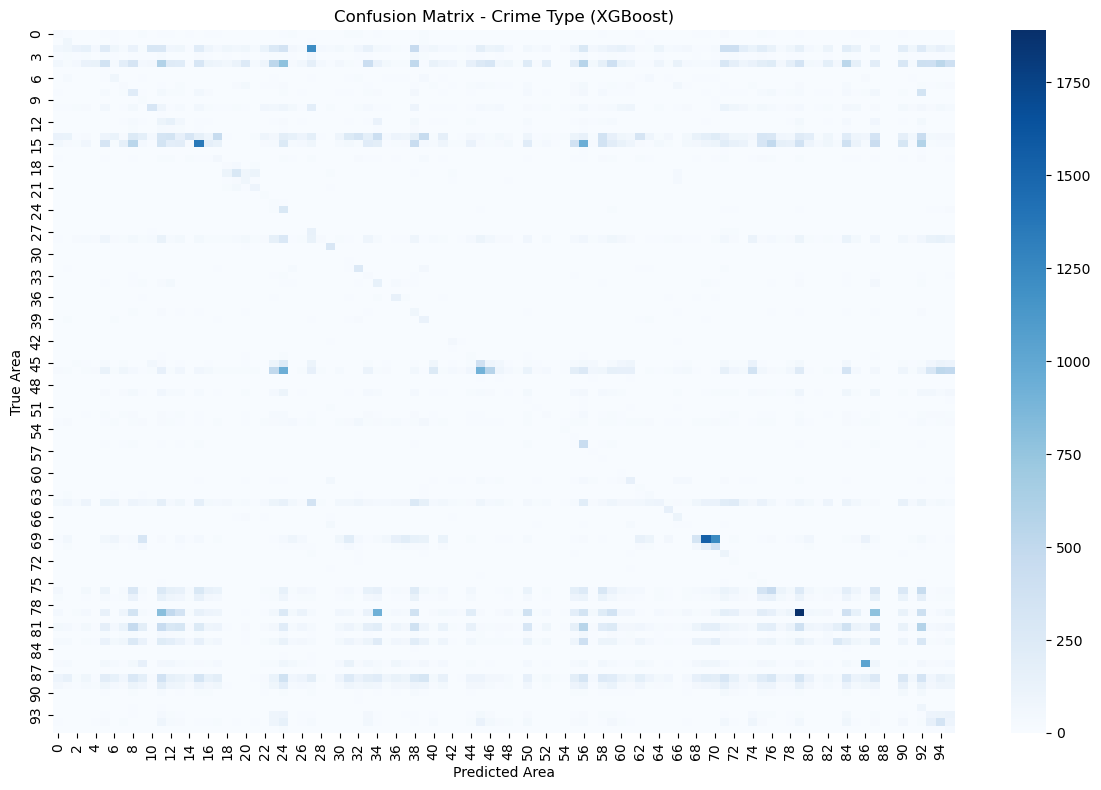

In [73]:
from sklearn.utils.class_weight import compute_sample_weight


df_crime_area = df.copy()

cols_to_drop = ['DR_NO', 'Date Rptd', 'DATE OCC', 'LOCATION', 'MO Description',
                'Status Desc', 'Vict Descent', 'Victim Descent', 'Crm Cd Desc', 'LAT', 'LON', 'AREA']
df_crime_area.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 1. Label encode AREA NAME as a feature
le_area = LabelEncoder()
df_crime_area['Area_Label'] = le_area.fit_transform(df_crime_area['AREA NAME'])

# 2. Filter Crime Types with at least 100 observations
vc = df_crime_area['Crime Type'].value_counts()
valid_crimes = vc[vc >= 100].index
df_crime_area = df_crime_area[df_crime_area['Crime Type'].isin(valid_crimes)]

# 3. Label encode Crime Type
le_crime = LabelEncoder()
df_crime_area['Crime Type'] = le_crime.fit_transform(df_crime_area['Crime Type'])

# 4. Prepare data
X = df_crime_area.drop(columns=[
    'Crime Type', 'Crm Cd', 'AREA NAME',
    'Part 1-2', 'Mocodes'  # if these were excluded
])
y = df_crime_area['Crime Type']

# Encode all object columns
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 6. Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 7. Train XGBoost with sample weights
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train, y_train, sample_weight=sample_weights)

# 8. Predict and evaluate
y_pred = xgb.predict(X_test)

print("XGBoost Classification Report (Crime Type with AREA feature, Weighted):")
print(classification_report(
    y_test,
    y_pred,
    target_names=[str(label) for label in le_crime.classes_]
))

cm_area = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm_area, cmap='Blues', annot=False)
plt.title('Confusion Matrix - Crime Type (XGBoost)')
plt.xlabel('Predicted Area')
plt.ylabel('True Area')
plt.tight_layout()
plt.show()

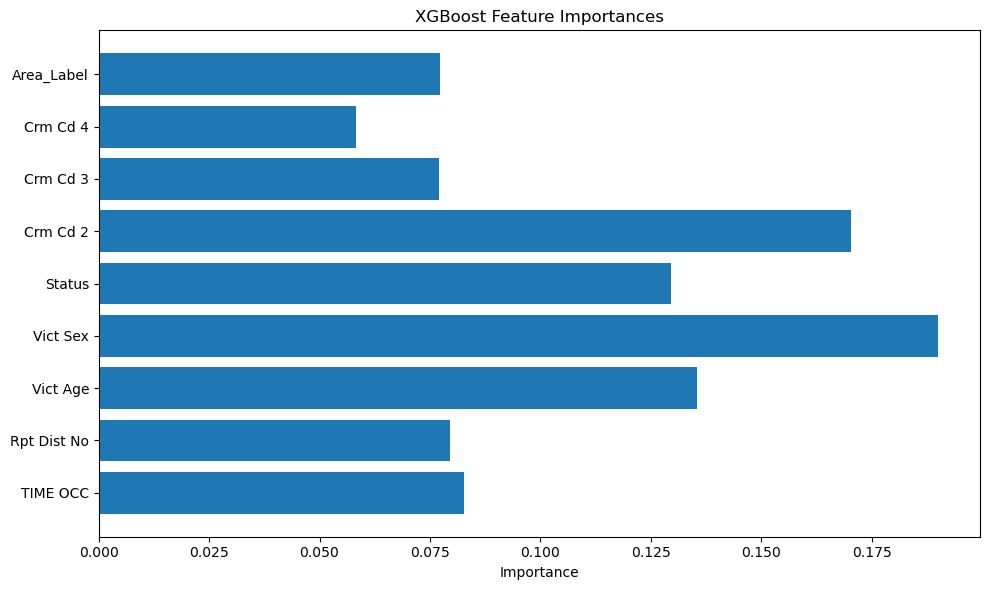

In [74]:
importances = xgb.feature_importances_   # Extract feature importance values
feature_names = X.columns                # Get feature names

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)      # Plot as horizontal bars
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()